<a href="https://colab.research.google.com/github/Zia-Ul-Hasan/Churn-Prediction-IBM-telco/blob/main/scratchcode10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd
import numpy as np
from sklearn import metrics
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Load the dataset
path = 'Telco_customer_churn.xlsx'
df = pd.read_excel(path)

# Dropping unnecessary columns
df = df.drop(['CustomerID', 'Country', 'Count', 'State', 'Zip Code', 'Lat Long', 'Longitude', 'Latitude', 'City', 'Churn Score', 'Churn Label'], axis=1)

# Replacing specific values
def replace_t(df):
    df.replace({'No internet service': 'No', 'No phone service': 'No'}, inplace=True)
    return df

df = replace_t(df)

# Convert data types
df['Monthly Charges'] = df['Monthly Charges'].astype(float)
df['CLTV'] = df['CLTV'].astype(float)
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
df['Tenure Months'] = pd.to_numeric(df['Tenure Months'], errors='coerce')
df['Churn Value'] = pd.to_numeric(df['Churn Value'], errors='coerce')

#outlier detection



# Remove rows with missing Total Charges
df = df.dropna(subset=['Total Charges'])
df_copy= df
df.to_csv('isko_check_kar.csv')
# Splitting the dataset into features and target variables
y1 = df['Churn Value']
x1 = df.drop(columns=['Churn Value', 'Churn Reason'])

# Identifying columns for encoding
num_col = []
LE_col = []
OE_col = []
for col in x1.columns:
    if pd.api.types.is_numeric_dtype(x1[col]):
        num_col.append(col)
    else:
        if x1[col].nunique() == 2:
            LE_col.append(col)
        elif x1[col].nunique() > 2:
            OE_col.append(col)

# One-hot encoding function
def one_hot_encode_columns(df, columns):
    for column in columns:
        one_hot = pd.get_dummies(df[column], prefix=column)
        df = df.drop(column, axis=1)
        df = pd.concat([df, one_hot], axis=1)
    return df

# Label encoding function
LE = LabelEncoder()
def label_encode_columns(df, columns):
    for col in columns:
        df[col] = LE.fit_transform(df[col])
    return df

# Splitting the dataset into training and test sets
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.2, random_state=42)

# Applying one-hot encoding and label encoding
x1_train = one_hot_encode_columns(x1_train, OE_col)
x1_test = one_hot_encode_columns(x1_test, OE_col)
x1_train = label_encode_columns(x1_train, LE_col)
x1_test = label_encode_columns(x1_test, LE_col)

# Apply SMOTETomek sampling
smote_tomek = SMOTETomek(random_state=42)
x1_resampled, y1_resampled = smote_tomek.fit_resample(x1_train, y1_train)

# Train Random Forest
rf = RandomForestClassifier(random_state=42,n_estimators=500, max_depth=20, criterion='entropy', min_samples_split=10, min_samples_leaf=4,max_features='sqrt', bootstrap=False, class_weight='balanced')

rf.fit(x1_resampled, y1_resampled)
y1_pred_rf = rf.predict(x1_test)
rf_results = {
    "confusion_matrix": confusion_matrix(y1_test, y1_pred_rf),
    "classification_report": classification_report(y1_test, y1_pred_rf)
}

# Apply ADASYN sampling
ada = ADASYN(random_state=130)
x1_resampled_ada, y1_resampled_ada = ada.fit_resample(x1_train, y1_train)

# Train Balanced Random Forest
brf = BalancedRandomForestClassifier(random_state=42,n_estimators= 700, max_depth=25, criterion='log_loss', min_samples_split=15, min_samples_leaf=3, max_features='log2', bootstrap=False)
brf.fit(x1_resampled_ada, y1_resampled_ada)
y1_pred_brf = brf.predict(x1_test)
brf_results = {
    "confusion_matrix": confusion_matrix(y1_test, y1_pred_brf),
    "classification_report": classification_report(y1_test, y1_pred_brf)
}

# Train Logistic Regression
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(x1_resampled_ada, y1_resampled_ada)
y1_pred_log_reg = log_reg.predict(x1_test)
log_reg_results = {
    "confusion_matrix": confusion_matrix(y1_test, y1_pred_log_reg),
    "classification_report": classification_report(y1_test, y1_pred_log_reg)
}

print("Random Forest Results")
print(rf_results["confusion_matrix"])
print(rf_results["classification_report"])

print("Balanced Random Forest Results")
print(brf_results["confusion_matrix"])
print(brf_results["classification_report"])

print("Logistic Regression Results")
print(log_reg_results["confusion_matrix"])
print(log_reg_results["classification_report"])


/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Random Forest Results
[[862 150]
 [138 257]]
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1012
           1       0.63      0.65      0.64       395

    accuracy                           0.80      1407
   macro avg       0.75      0.75      0.75      1407
weighted avg       0.80      0.80      0.80      1407

Balanced Random Forest Results
[[861 151]
 [136 259]]
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1012
           1       0.63      0.66      0.64       395

    accuracy                           0.80      1407
   macro avg       0.75      0.75      0.75      1407
weighted avg       0.80      0.80      0.80      1407

Logistic Regression Results
[[854 158]
 [130 265]]
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      1012
           1       0.63      0.67      0.65       395

    accuracy                    

In [16]:
df2 = df_copy
#print (df2.isnull().sum())
df2 = df2.dropna(subset=['Churn Reason'])
df2.drop('Churn Value', axis= 1)
y2= df2['Churn Reason']
y2=pd.DataFrame(y2)
x2 = df2.drop('Churn Reason', axis= 1)

x2_test, x2_train, y2_test, y2_train = train_test_split(x2, y2, test_size=0.2, random_state=42)
y2_test['Churn Reason'] = LE.fit_transform(y2_test['Churn Reason'])

y2_train['Churn Reason'] = LE.fit_transform(y2_train['Churn Reason'])
x2_train = one_hot_encode_columns(x2_train, OE_col)
x2_test = one_hot_encode_columns(x2_test, OE_col)
x2_train = label_encode_columns(x2_train, LE_col)
x2_test = label_encode_columns(x2_test, LE_col)

#print(f' this is x2 train {x2_train.head(1)}')
#print(f' this is y2 train {y2_train.head(1)}')
#print(f' this is x2 test {x2_test.head(1)}')
#print(f' this is y2 test {y2_test.head(1)}')

#Rf2 = RandomForestClassifier(random_state=42,n_estimators=500, max_depth=20, criterion='entropy', min_samples_split=10, min_samples_leaf=4,max_features='sqrt', bootstrap=False, class_weight='balanced')
# Best Parameters Output: {bootstrap = True, max_features = 16, max_depth = 4, n_estimators = 1000, criterion = 'gini'}
#Rf2.fit(x2_train,y2_train['Churn Reason'].ravel())
#Rf2_predict = Rf2.predict(x2_test)

#Rf2_results = {
 #   "confusion_matrix": confusion_matrix(y2_test, Rf2_predict),
  #  "classification_report": classification_report(y2_test, Rf2_predict)
#}
#print(Rf2)




#parameter_grid = {
 #   'n_estimators': [ 700, 1000],
  #  'max_features': ['sqrt', 'log2'],
   # 'max_depth' : [2,4,5,6],
    #'criterion' :['gini', 'entropy'],
    #'bootstrap': [True, False]
#}
#Rf2 = RandomForestClassifier()
#clf = GridSearchCV(Rf2, parameter_grid, cv = 10, scoring = 'accuracy', n_jobs = -1, verbose = 1)
#clf.fit(x2_train, y2_train)
#from sklearn import metrics
#print(clf.best_params_)
#print(clf.best_score_)
# Best Parameters Output: {bootstrap = True, max_features = 16, max_depth = 4, n_estimators = 1000, criterion = 'gini'}
# Best Score with Parameters: 0.9414807104745758

In [17]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', k_neighbors=2)
smote_tomek = SMOTETomek(smote=smote, random_state=42)
x2_resampled, y2_resampled = smote_tomek.fit_resample(x2_train, y2_train)
Rf2 = RandomForestClassifier( random_state=42, bootstrap= True, criterion= 'entropy',min_samples_split=7, max_depth= 4, max_features= 'sqrt', n_estimators=700)
Rf2.fit(x2_resampled,y2_resampled['Churn Reason'].ravel())
Rf2_predict = Rf2.predict(x2_test)
Rf2_results = {
    "confusion_matrix": confusion_matrix(y2_test, Rf2_predict),
    "classification_report": classification_report(y2_test, Rf2_predict)
}

print("Confusion Matrix:\n", Rf2_results["confusion_matrix"])
print("Classification Report:\n", Rf2_results["classification_report"])

Confusion Matrix:
 [[ 2  0  4  1  8  0 18  1 14  4  8  5  1  2  4  7  1  7 10  5]
 [ 1  2  6  5 14  1 23  1 19 10  8 14  1  0  2 14  5 11  9  6]
 [ 1  0  5  0 13  0 13  0  8  5 10  5  1  4  3 11  1  8  6  5]
 [ 1  0  6  2  7  1 29  0 11  3  9 15  1  1  4  1  0 11 13  3]
 [ 1  0  5  1 17  2 26  0 19  6 14  9  2  4  7 11  4  8  6  7]
 [ 1  0  7  1 12  0 25  0 21  7 10 11  0  2  7  3  4  5 14  2]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1  0  0]
 [ 2  0  4  0  7  0 19  0 13  8 16  8  1  2  7 11  4 11  8  6]
 [ 0  0  1  0  6  0  7  0  8  2  2  5  0  2  0  5  0  3  5  0]
 [ 0  0  2  0  4  0  3  0  5  2  3  4  0  0  1  2  0  3  2  3]
 [ 0  1  2  1  5  1 15  0  7  3  9  4  0  2  5  3  2  5  3  2]
 [ 0  0  0  0  0  0 10  0  5  3  5  2  0  1  1  2  0  4  0  5]
 [ 0  0  1  0  4  0  5  0  0  2  2  2  0  0  2  2  1  5  3  4]
 [ 0  0  3  0  2  0  7  0  6  4  3  2  0  0  5  2  2  4  2  1]
 [ 2  0  7  1  3  0 15  0 10  5  7  8  0  1  2  6  2  8  4  3]
 [ 0  0  2  1  1  0  0  0  3  2  1  

In [21]:
#print(df2['Churn Reason'].value_counts())

df2=df2.replace({'Attitude of support person': 'Customer Support Issues', 'Poor expertise of phone support': 'Customer Support Issues', 'Poor expertise of online support': 'Customer Support Issues', 'Attitude of service provider': 'Customer Support Issues'})
df2=df2.replace({'Service dissatisfaction': 'Service Dissatisfaction', 'Product dissatisfaction': 'Service Dissatisfaction', 'Network reliability': 'Service Dissatisfaction', 'Limited range of services': 'Service Dissatisfaction','Lack of affordable download/upload speed': 'Service Dissatisfaction'})
df2=df2.replace({'Competitor offered higher download speeds': 'Competitor Advantages', 'Competitor offered more data': 'Competitor Advantages', 'Competitor made better offer': 'Competitor Advantages', 'Competitor had better devices': 'Competitor Advantages'})
df2=df2.replace({'Price too high': 'Price-Related Issues', 'Extra data charges': 'Price-Related Issues', 'Long distance charges': 'Price-Related Issues'})
df2=df2.replace({'Moved': 'Unavailable', 'Deceased': 'Unavailable', "Don't know": 'Unavailable'})
print(df2['Churn Reason'].value_counts())
df2.to_csv('preprocess2.csv')


Y= df2['Churn Reason']
Y=pd.DataFrame(Y)
#print(Y['Churn Reason'].unique())
X = df2.drop('Churn Reason', axis= 1)

X_test, X_train, Y_test, Y_train = train_test_split(X, Y, test_size=0.2, random_state=42)
Y_test['Churn Reason'] = LE.fit_transform(Y_test['Churn Reason'])
print(Y_train)
Y_train['Churn Reason'] = LE.fit_transform(Y_train['Churn Reason'])
X_train = one_hot_encode_columns(X_train, OE_col)
X_test = one_hot_encode_columns(X_test, OE_col)
X_train = label_encode_columns(X_train, LE_col)
X_test = label_encode_columns(X_test, LE_col)

scaler = StandardScaler()
X[num_col] = scaler.fit_transform(X[num_col])

parameter_grid = {
    'n_estimators': [ 550, 700, 1000, 1200],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [2,4,5,6,7],
    'criterion' :['gini', 'entropy'],
    'bootstrap': [True, False]
}
#Rf3 = RandomForestClassifier()
#clf = GridSearchCV(Rf3, parameter_grid, cv = 10, scoring = 'accuracy', n_jobs = -1, verbose = 1)
#lf.fit(X_train, Y_train)

#print(clf.best_params_)
#print(clf.best_score_)

Churn Reason
Competitor Advantages              621
Service Dissatisfaction            382
Customer Support Issues            366
Unavailable                        213
Price-Related Issues               199
Lack of self-service on Website     88
Name: count, dtype: int64
                         Churn Reason
1700          Service Dissatisfaction
1488          Customer Support Issues
921   Lack of self-service on Website
275             Competitor Advantages
416             Competitor Advantages
...                               ...
439              Price-Related Issues
1296             Price-Related Issues
374             Competitor Advantages
271             Competitor Advantages
184             Competitor Advantages

[374 rows x 1 columns]


In [30]:
#{'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 700}
#0.1310099573257468
smote = SMOTE(sampling_strategy='auto', k_neighbors=2)
smote_tomek = SMOTETomek(smote=smote, random_state=42)
print(Y_train)
X_resampled, Y_resampled = smote_tomek.fit_resample(X_train, Y_train)
Rf4 = RandomForestClassifier( random_state=42, bootstrap= False, criterion= 'gini',min_samples_split=7, max_depth= 4, max_features= 'sqrt', n_estimators=700)
Rf4.fit(X_resampled,Y_resampled['Churn Reason'].ravel())
Rf4_predict = Rf4.predict(X_test)
Rf4_results = {
    "confusion_matrix": confusion_matrix(Y_test, Rf4_predict),
    "classification_report": classification_report(Y_test, Rf4_predict, output_dict=True)
}

print("Confusion Matrix:\n", Rf4_results["confusion_matrix"])
print("Classification Report:\n", Rf4_results["classification_report"])





log_reg2 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000, random_state=42)
log_reg2.fit(X_resampled,Y_resampled)
Y_pred6 = log_reg2.predict(X_test)

log_reg2_results = {
    "accuracy": accuracy_score(Y_test, Y_pred6),
    "classification_report": classification_report(Y_test, Y_pred6, output_dict=True)
}
# Evaluate the model
print("Accuracy:", accuracy_score(Y_test, Y_pred6))
print("Classification Report:\n", classification_report(Y_test, Y_pred6 ))

      Churn Reason
1700             4
1488             1
921              2
275              0
416              0
...            ...
439              3
1296             3
374              0
271              0
184              0

[374 rows x 1 columns]
Confusion Matrix:
 [[ 94 112  66  22  65 139]
 [ 47  68  38  20  48  64]
 [ 15  12  16   2   6  19]
 [ 28  39  22   8  20  43]
 [ 60  91  46  10  33  69]
 [ 32  39  25   8  27  42]]
Classification Report:
 {'0': {'precision': 0.34057971014492755, 'recall': 0.18875502008032127, 'f1-score': 0.24289405684754523, 'support': 498.0}, '1': {'precision': 0.1883656509695291, 'recall': 0.23859649122807017, 'f1-score': 0.21052631578947367, 'support': 285.0}, '2': {'precision': 0.07511737089201878, 'recall': 0.22857142857142856, 'f1-score': 0.11307420494699646, 'support': 70.0}, '3': {'precision': 0.11428571428571428, 'recall': 0.05, 'f1-score': 0.06956521739130435, 'support': 160.0}, '4': {'precision': 0.1658291457286432, 'recall': 0.106796116504854

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.20133779264214047
Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.28      0.31       498
           1       0.21      0.25      0.22       285
           2       0.08      0.20      0.12        70
           3       0.13      0.11      0.12       160
           4       0.17      0.13      0.15       309
           5       0.10      0.12      0.11       173

    accuracy                           0.20      1495
   macro avg       0.17      0.18      0.17      1495
weighted avg       0.22      0.20      0.21      1495



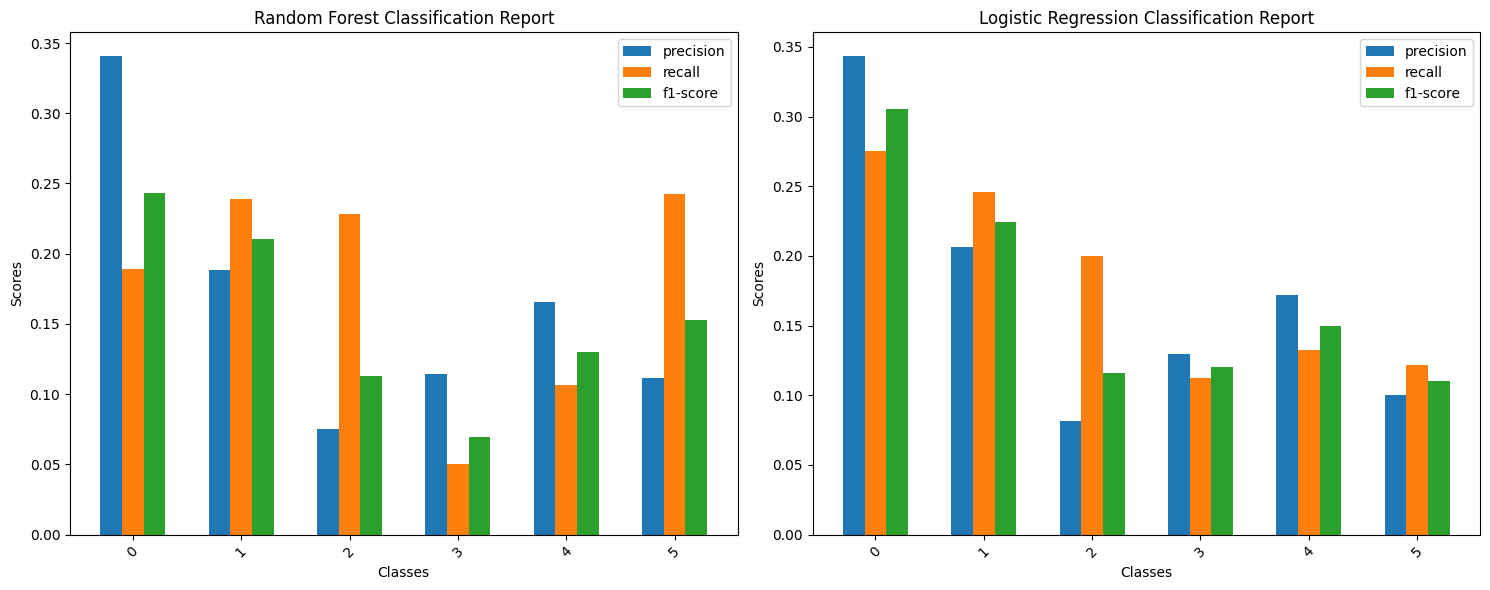

In [31]:
import matplotlib.pyplot as plt
def plot_classification_report(report, title='Classification Report', ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    classes = list(report.keys())[:-3]
    metrics = ['precision', 'recall', 'f1-score']
    data = {metric: [report[cls][metric] for cls in classes] for metric in metrics}

    x = np.arange(len(classes))
    width = 0.2

    for i, metric in enumerate(metrics):
        ax.bar(x + i*width, data[metric], width, label=metric)

    ax.set_xlabel('Classes')
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(x + width)
    ax.set_xticklabels(classes, rotation=45)
    ax.legend()

    plt.tight_layout()

# Plot the classification reports
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_classification_report(Rf4_results['classification_report'], title='Random Forest Classification Report', ax=axes[0])
plot_classification_report(log_reg2_results['classification_report'], title='Logistic Regression Classification Report', ax=axes[1])
plt.show()